In [1]:
import sys
sys.path.append("../../src")
import os
import datetime
import pandas as pd
import numpy as np
import numpy as np
from sindy_utils import library_size
from training import train_network
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_v2_behavior()

from time import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import pickle 
import copy
import subprocess as sp
from matplotlib.patches import Rectangle
import matplotlib.patches as patches
import seaborn as sns
from copy import deepcopy
from matplotlib.ticker import FormatStrFormatter

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
def get_gpu_memory():
  _output_to_list = lambda x: x.decode('ascii').split('\n')[:-1]

  ACCEPTABLE_AVAILABLE_MEMORY = 1024
  COMMAND = "nvidia-smi --query-gpu=memory.free --format=csv"
  memory_free_info = _output_to_list(sp.check_output(COMMAND.split()))[1:]
  memory_free_values = [int(x.split()[0]) for i, x in enumerate(memory_free_info)]
  return memory_free_values

device_list = tf.config.list_physical_devices('GPU')
free_mem = get_gpu_memory()
for i,gpu in enumerate(device_list):
    print(f'{gpu}: free memory: {free_mem[i]}')

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'): free memory: 8611
PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'): free memory: 15055
PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'): free memory: 8481
PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU'): free memory: 16149


In [4]:
# specify which GPU to use
config = tf.ConfigProto(log_device_placement=False, gpu_options=tf.GPUOptions(allow_growth=True,visible_device_list='1'))

# Load data

In [5]:
def preprocess_data(data, vel):
    for i in range(len(data['data'])):
        if vel == 1:
            data['data'][i]['x'] = data['data'][i].pop('u')
            data['data'][i]['dx'] = data['data'][i].pop('du')
            data['data'][i].pop('v')
            data['data'][i].pop('dv')
        elif vel == 2:
            data['data'][i]['x'] = data['data'][i].pop('v')
            data['data'][i]['dx'] = data['data'][i].pop('dv')
            data['data'][i].pop('u')
            data['data'][i].pop('du')
        elif vel == 3:
            data['data'][i]['x'] = np.hstack((data['data'][i]['u'], data['data'][i]['v']))
            data['data'][i]['dx'] = np.hstack((data['data'][i]['du'], data['data'][i]['dv']))
    return data

In [6]:
# load training data
vel = 3    # 1: u; 2: v; 3: u and v
scaled = 0 # 1: normalize data
option = 2 # 1: mean=0, std=1; 2: max=1; 3: [0,1]
Re = 10000
ic = 2     # initial condition, 1: Sine; 2: Gaussian
nx = 60
ny = nx
nt = 200
tstop = 1

amp_train = np.linspace(0.7, 0.9, 2)
width_train = np.linspace(0.9, 1.1, 2)
num_train = amp_train.size * width_train.size # initial number of training data
train_data = pickle.load(open(f"./data/local{num_train}_Re{Re}_tstop{tstop:.1f}_nt{nt}_nx{nx}.p", "rb"))
train_data = preprocess_data(train_data, vel)
num_sindy = len(train_data['data'])
input_dim = train_data['data'][0]['x'].shape[1]

for i in range(num_sindy):
    print(f"train case {i}: params: {train_data['param'][i]}, x shape: {train_data['data'][i]['x'].shape}")

# load testing data 
amp_test = np.linspace(0.7, 0.9, 21)
width_test = np.linspace(0.9, 1.1, 21)
num_test = amp_test.size * width_test.size
test_data = pickle.load(open(f"./data/local{num_test}_Re{Re}_tstop{tstop:.1f}_nt{nt}_nx{nx}.p", "rb"))
test_data = preprocess_data(test_data, vel)

train case 0: params: [0.7 0.9], x shape: (201, 7200)
train case 1: params: [0.7 1.1], x shape: (201, 7200)
train case 2: params: [0.9 0.9], x shape: (201, 7200)
train case 3: params: [0.9 1.1], x shape: (201, 7200)


In [7]:
grid1, grid2 = np.meshgrid(amp_train, width_train)
train_param = np.hstack((grid1.flatten().reshape(-1,1), grid2.flatten().reshape(-1,1)))
grid1, grid2 = np.meshgrid(amp_test, width_test)
test_param = np.hstack((grid1.flatten().reshape(-1,1), grid2.flatten().reshape(-1,1)))

train_idx = []
for i in range(num_test):
    for j in range(num_train):
        if np.abs(test_param[i,0]-train_param[j,0]) < 1e-8 and \
        np.abs(test_param[i,1]-train_param[j,1]) < 1e-8:
            train_idx.append(i)
print(train_idx)

[0, 1, 2, 3]


# Set up model and training parameters

In [8]:
params = {}

params['seed'] = 1 # random seed
params['config'] = config
params['num_sindy'] = num_sindy
params['param'] = train_data['param']
params['train_idx'] = train_idx
params['input_dim'] = input_dim
params['latent_dim'] = 3
params['model_order'] = 1
params['poly_order'] = 1
params['include_sine'] = False
params['include_cosine'] = False
params['include_costant'] = True
params['library_dim'] = library_size(params['latent_dim'], params['poly_order'], 
                                     params['include_sine'], params['include_cosine'], 
                                     params['include_costant'])

# sequential thresholding parameters
params['sequential_thresholding'] = False
params['coefficient_threshold'] = 0.1
params['threshold_frequency'] = 500
params['coefficient_mask'] = np.ones((params['library_dim'], params['latent_dim']))
params['coefficient_initialization'] = 'constant'

# loss function weighting
params['loss_weight_decoder'] = 1.0
params['loss_weight_sindy_x'] = 1e0
params['loss_weight_sindy_z'] = 1e-2
params['loss_weight_sindy_regularization'] = 0
params['diff'] = 'symb' # 'symb': symbolic diff (only for fully connected Autoencoder), 'auto': automatic diff
params['activation'] = 'sigmoid'
params['widths'] = [100]

# training parameters
params['epoch_size'] = train_data['data'][0]['x'].shape[0]
params['batch_size'] = 100
params['learning_rate'] = 1e-4

params['fig_path'] = os.getcwd() + '/fig/nCase441_k1_MRN_nt200_ld3_p1_lr1e-4_width100_lamb1_1_1e-2_upEp2e4_subsize50_tend1/'
params['print_progress'] = True
params['print_frequency'] = 100
params['save_frequency'] = 1000

# training time cutoffs
params['max_epochs'] = 600000
params['refinement_epochs'] = 0

# Greedy algorithm
params['update_epoch'] = 20000  # update training set for every 2000 epochs
params['tol'] = 0.02            # max error allowed in the parameter space
params['tol2'] = 5              # max relative error allowed in the parameter space
params['sindy_max'] = 36        # max number of local SINDys; if tolerance is used as a termination criterior, set it as None
params['convex_knn'] = 1        # the number nearest local SINDys used for convex interpolation if used
params['test_data'] = test_data # loaded test data
params['test_param'] = np.hstack((amp_test.reshape(-1,1), width_test.reshape(-1,1)))    # parameters of test data
params['num_test'] = num_test   # number of test cases
params['coeff_exist'] = False   # flag to indicate whether to initialize model coefficients with pescribed values
params['retrain'] = False       # whether to retrain the model

# Error indicator:
# 1: max relative error (if test data is available) 
# 2: residual norm (mean), 1D Burger's eqn
# 3: residual norm (mean), 2D Burger's eqn
params['err_type'] = 3                            
params['subsize'] = int(0.5 * num_test)           # initial number of random testing cases for Greedy search
params['subsize_max'] = 50                        # max percentage of random testing cases for Greedy search

# Adaptive approach for tol of error indicator:
# 'mean': use mean ratios between error indicator and max relative errors
# 'reg_mean': use linear regression line
# 'reg_max': use linear regression line shifted by std to upper bound
# 'reg_min': use linear regression line shifted by std to lower bound, more conservative
params['adaptive'] = 'reg_max' 


# PDE parameters
params['pde'] = {}
params['pde']['Re'] = Re
params['pde']['nx'] = nx
params['pde']['nt'] = nt
params['pde']['tstop'] = tstop
params['pde']['ic'] = ic

# normalization
params['scaled'] = scaled # if data is normalized

In [9]:
if params['retrain']:
    save_name = 'burger_2022_02_28_23_54_25'
    params = pickle.load(open(params['fig_path'] + save_name + '_params.pkl', 'rb'))
    params['retrain'] = True
    params['coeff_exist'] = True  # flag to indicate whether to initialize model coefficients with pescribed values
    params['save_name'] = save_name
    params['max_epochs'] = 600000
    params['update_epoch'] = 20000  # update training set for every 2000 epochs
    params['save_frequency'] = 500
    
    for i in params['train_idx'][4:]:
        train_data['data'].append(test_data['data'][i])
        train_data['param'].append(test_data['param'][i])

# Run training experiments

In [10]:
num_experiments = 1
df = pd.DataFrame()
timer = []
timer.append(time())
for i in range(num_experiments):
    print('EXPERIMENT %d' % i)

    if not params['retrain']:
        params['save_name'] = 'burger_' + datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
    tf.reset_default_graph()
    results_dict = train_network(train_data, params)
    df = df.append({**results_dict, **params}, ignore_index=True)
    
timer.append(time())
df.to_pickle(params['fig_path'] + 'experiment_results_' + datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S") + '.pkl')
print(f'training time: {(timer[-1]-timer[0])/60:.2f} mins')

EXPERIMENT 0
* Evaluating
  Time: 0.00 s, Case: [0.7 0.9], Tol: 0.02000, Max Error: -1.000000
Epoch 0
  train loss: 1.5942e+01, decoder: 1.1460e-01, sindy-x: 1.2705e-02, sindy-z: 1.5814e+02, sindy-reg: 3.9975
Epoch 100
  train loss: 1.8406e+00, decoder: 1.0004e-04, sindy-x: 1.1156e-03, sindy-z: 1.8394e+01, sindy-reg: 3.8488
Epoch 200
  train loss: 1.6126e-01, decoder: 8.4510e-05, sindy-x: 1.1456e-03, sindy-z: 1.6003e+00, sindy-reg: 3.7193
Epoch 300
  train loss: 4.9299e-03, decoder: 9.6714e-05, sindy-x: 1.2122e-03, sindy-z: 3.6210e-02, sindy-reg: 3.6779
Epoch 400
  train loss: 2.1989e-03, decoder: 1.0675e-04, sindy-x: 1.2436e-03, sindy-z: 8.4856e-03, sindy-reg: 3.6743
Epoch 500
  train loss: 1.8581e-03, decoder: 1.1694e-04, sindy-x: 1.2466e-03, sindy-z: 4.9449e-03, sindy-reg: 3.6738
Epoch 600
  train loss: 1.7739e-03, decoder: 1.4305e-04, sindy-x: 1.2381e-03, sindy-z: 3.9271e-03, sindy-reg: 3.6737
Epoch 700
  train loss: 1.7579e-03, decoder: 2.1456e-04, sindy-x: 1.2141e-03, sindy-z: 3.

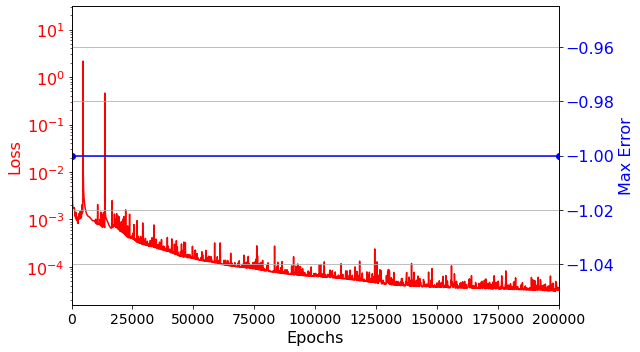

In [11]:
# history of validation loss
train_loss = np.array(df['training_losses'][0]).squeeze()
test_loss = np.array(df['testing_losses'][0]).squeeze()

fig, ax1 = plt.subplots(figsize=(9,5))
xt = np.linspace(1,df['epoch_count'],train_loss.shape[0])
ax1.plot(xt, train_loss[:,0], 'r', label='Train')
ax1.set_yscale('log')
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
ax1.set_xlabel('Epochs', fontsize=16)
ax1.set_ylabel('Loss', color='r', fontsize=16)
ax1.set_xlim(0, params['epoch_count'])
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=16)
ax1.tick_params(axis='y', labelcolor='r')

ax2 = ax1.twinx()
xt = np.linspace(1,df['epoch_count'],test_loss.shape[0])
ax2.plot(xt, test_loss, 'b-o', label='Val')
ax2.set_ylabel('Max Error', color='b', fontsize=16)
ax2.tick_params(axis='both', labelsize=16)
ax2.tick_params(axis='y', labelcolor='b')

plt.grid()
plt.tight_layout()
plt.savefig(f"{params['fig_path']}/loss_{params['loss_weight_sindy_x']:.1e}_{params['loss_weight_sindy_z']:.1e}_{params['loss_weight_sindy_regularization']:.1e}.png")